# Generation of the graph structure as input data for the GNN

In [118]:
import pandas as pd
import os 
import json
import re

import numpy as np
import math

import geopandas as gpd

import numpy as np


from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

source='spotify' #'lfm' or 'spotify'

In [119]:
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2022_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])

if source== 'lfm':
    ranking_df= pd.read_csv(os.path.join('data', 'LMF-2b', 'clean_ranking_2005_2020_lfm.csv'), index_col=0, parse_dates=['Date', 'release_date'])
    
ranking_df.head()

ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [120]:
global_initial_date = ranking_df['Date'].min()
global_initial_date

Timestamp('2017-01-01 00:00:00')

In [121]:
raw_spotify_countries = ranking_df['Region'].unique()
raw_spotify_countries

array(['Ecuador', 'Portugal', 'Panama', 'Italy', 'Germany', 'Finland',
       'Estonia', 'Hungary', 'Spain', 'Peru', 'Slovakia', 'Ireland',
       'Indonesia', 'Iceland', 'Brazil', 'Canada', 'Belgium', 'Uruguay',
       'CostaRica', 'Malaysia', 'Mexico', 'France', 'Argentina', 'Norway',
       'Lithuania', 'Philippines', 'Taiwan', 'NewZealand', 'Turkey',
       'USA', 'ElSalvador', 'Chile', 'Japan', 'Honduras', 'Guatemala',
       'Switzerland', 'Denmark', 'Bolivia', 'Poland', 'Austria', 'Sweden',
       'CzechRepublic', 'Netherlands', 'Columbia', 'Singapore',
       'DominicanRepublic', 'Luxemborg', 'UnitedKingdom', 'Paraguay',
       'Australia', 'Latvia', 'Greece', 'HongKong', 'Russia',
       'UnitedArabEmirates', 'Belarus', 'India', 'SouthAfrica', 'Romania',
       'Ukraine', 'Egypt', 'Nigeria', 'Korea', 'Kazakhstan',
       'SaudiArabia', 'Nicaragua', 'Marocco', 'Israel', 'Bulgaria',
       'Vietnam'], dtype=object)

In [122]:
len(raw_spotify_countries)

70

In [123]:
spotify_countries= ['Ecuador', 'Portugal', 'Panama', 'Italy', 'Germany', 'Finland',
            'Estonia', 'Hungary', 'Spain', 'Peru', 'Slovakia', 'Ireland',
            'Indonesia', 'Iceland', 'Brazil', 'Canada', 'Belgium', 'Uruguay',
            'Costa Rica', 'Malaysia', 'Mexico', 'France', 'Argentina', 'Norway',
            'Lithuania', 'Philippines', 'Taiwan','New Zealand', 'Turkey',
            'United States of America', 'El Salvador', 'Chile', 'Japan', 'Honduras', 'Guatemala',
            'Switzerland', 'Denmark', 'Bolivia', 'Poland', 'Austria', 'Sweden',
            'Czechia', 'Netherlands', 'Colombia', 'Singapore',
            'Dominican Rep.', 'Luxembourg', 'United Kingdom', 'Paraguay',
            'Australia', 'Latvia', 'Greece', 'Hong Kong', 'Russia',
            'United Arab Emirates', 'Belarus', 'India', 'South Africa', 'Romania',
            'Ukraine', 'Egypt', 'Nigeria', 'South Korea', 'Kazakhstan',
            'Saudi Arabia', 'Nicaragua', 'Morocco', 'Israel', 'Bulgaria', 'Vietnam']

In [124]:
len(spotify_countries)

70

## Edges from the patterns

In [125]:
def keep_nlargest(df, n):
    largest=df.groupby('origin')['weight'].nlargest(n).to_frame()
    l=largest.index.tolist()
    index_to_keep= [j[1] for j in l]
    return df.loc[index_to_keep]

names_to_change ={'Bolivia (Plurinational State of)': 'Bolivia',
                 'Costa Rica': 'CostaRica',
                 'New Zealand': 'NewZealand',
                 'United States of America': 'USA',
                 'El Salvador': 'ElSalvador',
                 'Czechia': 'CzechRepublic',
                 'Colombia': 'Columbia',
                 'United Kingdom': 'UnitedKingdom',
                 'China, Hong Kong SAR': 'HongKong',
                 'Russian Federation': 'Russia',
                 'United Arab Emirates': 'UnitedArabEmirates',
                 'South Africa': 'SouthAfrica',
                 'Saudi Arabia': 'SaudiArabia'}

In [126]:
#edges_df= pd.read_csv(os.path.join('data', 'graphs', '05_mean_edges.csv'), index_col=0)
edges_df= pd.read_csv(os.path.join('data', 'human_migration_flows', f'song_OD_dataframe_{source}.csv'), index_col=0)
edges_df= edges_df.rename(columns={'origen':'origin', 'destino':'destination', 'viajes':'weight'})
edges_df['origin']= edges_df['origin'].apply(lambda x: names_to_change[x] if x in names_to_change else x)
edges_df['destination']= edges_df['destination'].apply(lambda x: names_to_change[x] if x in names_to_change else x)

edges_df.head()

,origin,destination,weight
0,Brazil,Portugal,200
1,Paraguay,Uruguay,22
2,Uruguay,Argentina,121
3,Argentina,Bolivia,16
4,Panama,Columbia,17


In [127]:
{u:v for v,u in names_to_change.items()}

{'Bolivia': 'Bolivia (Plurinational State of)',
 'CostaRica': 'Costa Rica',
 'NewZealand': 'New Zealand',
 'USA': 'United States of America',
 'ElSalvador': 'El Salvador',
 'CzechRepublic': 'Czechia',
 'Columbia': 'Colombia',
 'UnitedKingdom': 'United Kingdom',
 'HongKong': 'China, Hong Kong SAR',
 'Russia': 'Russian Federation',
 'UnitedArabEmirates': 'United Arab Emirates',
 'SouthAfrica': 'South Africa',
 'SaudiArabia': 'Saudi Arabia'}

In [128]:
top_to_keep= 5
edges_largest_df=keep_nlargest(edges_df, top_to_keep)
edges_largest_df.head()

,origin,destination,weight
356,Argentina,Uruguay,203
227,Argentina,Paraguay,44
228,Argentina,Peru,28
256,Argentina,Chile,19
3,Argentina,Bolivia,16


In [129]:
edges_largest_df[edges_largest_df['origin']=='India']

,origin,destination,weight
669,India,UnitedArabEmirates,26
2552,India,Malaysia,7
2904,India,Canada,7
2915,India,SaudiArabia,6
722,India,Vietnam,4


In [130]:
edges_largest_df[edges_largest_df['destination']=='India']

,origin,destination,weight
3170,Kazakhstan,India,1


## Generate distance matrix among countries

In [131]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [132]:
ad_hoc_world_df = pd.DataFrame.from_records([('Hong Kong', 114.13077, 22.42439), ('Singapore', 113.79855, 1.37889)],
                                            columns='name x y'.split())
ad_hoc_world_gdf = gpd.GeoDataFrame(ad_hoc_world_df, geometry=gpd.points_from_xy(ad_hoc_world_df['x'], ad_hoc_world_df['y']))
ad_hoc_world_gdf= ad_hoc_world_gdf.drop(columns='x y'.split())
ad_hoc_world_gdf

,name,geometry
0,Hong Kong,POINT (114.13077 22.42439)
1,Singapore,POINT (113.79855 1.37889)


In [133]:
target_world= world[world['name'].isin(spotify_countries)]
target_world= target_world.drop(columns='pop_est continent iso_a3 gdp_md_est'.split())
target_world= pd.concat([target_world, ad_hoc_world_gdf])

In [134]:
target_world= target_world.set_index('name', drop=True)
target_world

,geometry
name,
Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
Kazakhstan,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
Indonesia,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
Argentina,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
...,...
Saudi Arabia,"POLYGON ((34.95604 29.35655, 36.06894 29.19749..."
Morocco,"POLYGON ((-2.16991 35.16840, -1.79299 34.52792..."
Egypt,"POLYGON ((36.86623 22.00000, 32.90000 22.00000..."


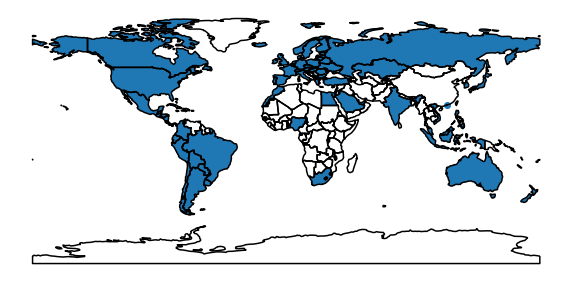

In [135]:
ax=target_world.plot(figsize=(10,10));
world.boundary.plot(ax=ax, color='black')
ax.set_axis_off()

In [136]:
distance_matrix= target_world.geometry.centroid.apply(lambda g: target_world.geometry.centroid.distance(g))
distance_matrix

name,Canada,United States of America,Kazakhstan,Indonesia,Argentina,Chile,Dominican Rep.,Russia,Norway,South Africa,...,Finland,Slovakia,Czechia,Japan,Paraguay,Saudi Arabia,Morocco,Egypt,Hong Kong,Singapore
name,,,,,,,,,,,,,,,,,,,,,
Canada,0.000000,21.389080,165.958970,224.777955,102.369506,103.981736,50.790067,194.946322,113.870312,152.810164,...,124.391177,118.338073,114.077875,237.403945,93.581246,147.466014,95.118603,132.676318,215.834145,220.294777
United States of America,21.389080,0.000000,179.901225,234.962850,93.993420,94.183213,49.949043,210.032788,130.197001,156.588123,...,140.078306,132.141632,127.998705,250.793386,87.712911,158.591210,105.373311,143.731923,227.922360,230.696571
Kazakhstan,165.958970,179.901225,0.000000,71.101404,156.655800,163.943543,140.830174,32.572489,55.897121,87.944916,...,44.193599,47.779950,51.974183,71.559126,144.558232,33.131247,77.886970,43.266682,53.465081,65.992288
Indonesia,224.777955,234.962850,71.101404,0.000000,185.596919,192.499235,189.067538,67.414369,124.457962,96.163687,...,113.012833,110.377709,114.567969,44.909631,177.063664,77.520949,129.875140,92.170442,24.865098,5.109219
Argentina,102.369506,93.993420,156.655800,185.596919,0.000000,7.295479,54.587942,189.011919,132.080659,90.457198,...,135.431873,119.400156,117.237570,215.990025,13.960186,124.823366,86.541406,113.432780,188.413815,182.723271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Saudi Arabia,147.466014,158.591210,33.131247,77.520949,124.823366,132.117654,115.098009,64.541987,53.589389,56.528540,...,44.335851,35.082243,38.853579,94.523368,113.283826,0.000000,53.249519,14.864218,69.635133,72.920018
Morocco,95.118603,105.373311,77.886970,129.875140,86.541406,93.452168,63.009640,110.004248,45.966432,67.686000,...,48.967813,33.689405,30.982382,146.691777,72.937329,53.249519,0.000000,38.413823,122.778155,125.499450
Egypt,132.676318,143.731923,43.266682,92.170442,113.432780,120.715217,100.595999,75.766408,45.008020,55.660700,...,38.170729,24.506774,27.422002,108.794044,101.293562,14.864218,38.413823,0.000000,84.385108,87.633851


In [137]:
max_dist= distance_matrix.max().max() * 2

## Composition of the language dataframe

In [138]:
language_raw= pd.read_csv(os.path.join('data','countries-languages.csv'))
language_raw

,Country,Languages Spoken
0,Afghanistan,"Dari Persian, Pashtu (both official), other Tu..."
1,Albania,"Albanian (Tosk is the official dialect), Greek"
2,Algeria,"Arabic (official), French, Berber dialects"
3,Andorra,"Catalán (official), French, Castilian, Portuguese"
4,Angola,"Portuguese (official), Bantu and other African..."
...,...,...
193,Vietnam,Vietnamese (official); English (increasingly f...
194,Western Sahara (proposed state),"Hassaniya Arabic, Moroccan Arabic"
195,Yemen,Arabic
196,Zambia,"English (official); major vernaculars: Bemba, ..."


In [139]:
def keep_all_languages_fn(raw_lang_lst):
    lang_lst= raw_lang_lst.replace(',','')
    lang_lst= lang_lst.replace(';','')
    lang_lst= lang_lst.replace(':','')
    lang_lst= lang_lst.replace('(','')
    lang_lst= lang_lst.replace(')','')

    lang_lst= [x for x in lang_lst.split() if x.istitle()]
    
    return set(lang_lst)

def keep_official_language_fn(raw_lang_lst):
    return re.split(' \(|; |, |:  | [0-9]+(\.[0-9]*)*%',raw_lang_lst)[0]

languages = language_raw.copy()
languages['Languages Spoken']= languages['Languages Spoken'].apply(lambda x:keep_official_language_fn(x))

In [140]:
countries_lang_lst = spotify_countries.copy()
countries_lang_lst.append('Czech Republic')
countries_lang_lst.append('United States')
countries_lang_lst.append('Dominican Republic')
countries_lang_lst.append('Korea, South')

In [141]:
target_countries_lang= languages[languages['Country'].isin(countries_lang_lst)]
target_countries_lang= target_countries_lang.reset_index(drop=True)

Ad-hoc operations to have the same country names across dataframes

In [142]:
target_countries_lang.loc[34,'Country']='South Korea'
target_countries_lang.loc[187,'Country']='United States of America'

target_countries_lang= target_countries_lang.append({'Country': 'Hong Kong', 'Languages Spoken': 'Chinese'}, ignore_index=True)
target_countries_lang = target_countries_lang.dropna()

In [143]:
target_countries_lang.tail()

,Country,Languages Spoken
65,United Kingdom,English
66,United States,English
67,Uruguay,Spanish
68,Vietnam,Vietnamese
70,Hong Kong,Chinese


In [144]:
import itertools

In [145]:
overlapping_lang = []
for c1,c2 in list(itertools.combinations(target_countries_lang['Country'], 2)):
    l1= target_countries_lang[target_countries_lang['Country']==c1]['Languages Spoken'].values[0]
    l2= target_countries_lang[target_countries_lang['Country']==c2]['Languages Spoken'].values[0]
    
    if l1==l2:
        overlapping_lang.append((c1,c2,1))
        overlapping_lang.append((c2,c1,1))

    else:
        overlapping_lang.append((c1,c2,0))
        overlapping_lang.append((c2,c1,0))

In [146]:
overlapping_lang_df = pd.DataFrame.from_records(overlapping_lang, columns='country1 country2 common_lang'.split())
overlapping_lang_df

,country1,country2,common_lang
0,Argentina,Australia,0
1,Australia,Argentina,0
2,Argentina,Austria,0
3,Austria,Argentina,0
4,Argentina,Belarus,0
...,...,...,...
4825,Vietnam,Uruguay,0
4826,Uruguay,Hong Kong,0
4827,Hong Kong,Uruguay,0
4828,Vietnam,Hong Kong,0


In [147]:
langs_matrix= overlapping_lang_df.pivot_table(index='country1', columns='country2', values='common_lang')
langs_matrix = langs_matrix.fillna(1)
langs_matrix.head()

country2,Argentina,Australia,Austria,Belarus,Belgium,Bolivia,Brazil,Bulgaria,Canada,Chile,...,Sweden,Switzerland,Taiwan,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam
country1,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Australia,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Austria,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belarus,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Generate the dicts to map the country names

In [148]:
country_names_mapping= {r:s for r,s in zip(raw_spotify_countries, spotify_countries)}
country_names_mapping

{'Ecuador': 'Ecuador',
 'Portugal': 'Portugal',
 'Panama': 'Panama',
 'Italy': 'Italy',
 'Germany': 'Germany',
 'Finland': 'Finland',
 'Estonia': 'Estonia',
 'Hungary': 'Hungary',
 'Spain': 'Spain',
 'Peru': 'Peru',
 'Slovakia': 'Slovakia',
 'Ireland': 'Ireland',
 'Indonesia': 'Indonesia',
 'Iceland': 'Iceland',
 'Brazil': 'Brazil',
 'Canada': 'Canada',
 'Belgium': 'Belgium',
 'Uruguay': 'Uruguay',
 'CostaRica': 'Costa Rica',
 'Malaysia': 'Malaysia',
 'Mexico': 'Mexico',
 'France': 'France',
 'Argentina': 'Argentina',
 'Norway': 'Norway',
 'Lithuania': 'Lithuania',
 'Philippines': 'Philippines',
 'Taiwan': 'Taiwan',
 'NewZealand': 'New Zealand',
 'Turkey': 'Turkey',
 'USA': 'United States of America',
 'ElSalvador': 'El Salvador',
 'Chile': 'Chile',
 'Japan': 'Japan',
 'Honduras': 'Honduras',
 'Guatemala': 'Guatemala',
 'Switzerland': 'Switzerland',
 'Denmark': 'Denmark',
 'Bolivia': 'Bolivia',
 'Poland': 'Poland',
 'Austria': 'Austria',
 'Sweden': 'Sweden',
 'CzechRepublic': 'Czechia'

In [149]:
country_to_code= {r:s for r,s in zip(sorted(raw_spotify_countries), range(len(raw_spotify_countries)))}
country_to_code

{'Argentina': 0,
 'Australia': 1,
 'Austria': 2,
 'Belarus': 3,
 'Belgium': 4,
 'Bolivia': 5,
 'Brazil': 6,
 'Bulgaria': 7,
 'Canada': 8,
 'Chile': 9,
 'Columbia': 10,
 'CostaRica': 11,
 'CzechRepublic': 12,
 'Denmark': 13,
 'DominicanRepublic': 14,
 'Ecuador': 15,
 'Egypt': 16,
 'ElSalvador': 17,
 'Estonia': 18,
 'Finland': 19,
 'France': 20,
 'Germany': 21,
 'Greece': 22,
 'Guatemala': 23,
 'Honduras': 24,
 'HongKong': 25,
 'Hungary': 26,
 'Iceland': 27,
 'India': 28,
 'Indonesia': 29,
 'Ireland': 30,
 'Israel': 31,
 'Italy': 32,
 'Japan': 33,
 'Kazakhstan': 34,
 'Korea': 35,
 'Latvia': 36,
 'Lithuania': 37,
 'Luxemborg': 38,
 'Malaysia': 39,
 'Marocco': 40,
 'Mexico': 41,
 'Netherlands': 42,
 'NewZealand': 43,
 'Nicaragua': 44,
 'Nigeria': 45,
 'Norway': 46,
 'Panama': 47,
 'Paraguay': 48,
 'Peru': 49,
 'Philippines': 50,
 'Poland': 51,
 'Portugal': 52,
 'Romania': 53,
 'Russia': 54,
 'SaudiArabia': 55,
 'Singapore': 56,
 'Slovakia': 57,
 'SouthAfrica': 58,
 'Spain': 59,
 'Sweden': 

In [150]:
values=[(s,u,v) for s,u,v in zip(sorted(spotify_countries), sorted(langs_matrix.index),sorted(distance_matrix.index))]
country_names_table = pd.DataFrame.from_records(values, columns='key_name lang_name dist_name'.split())
country_names_table= country_names_table.set_index('key_name')
country_names_table.head()

,lang_name,dist_name
key_name,,
Argentina,Argentina,Argentina
Australia,Australia,Australia
Austria,Austria,Austria
Belarus,Belarus,Belarus
Belgium,Belgium,Belgium


In [151]:
country_names_table.tail()

,lang_name,dist_name
key_name,,
United Arab Emirates,United Arab Emirates,United Arab Emirates
United Kingdom,United Kingdom,United Kingdom
United States of America,United States,United States of America
Uruguay,Uruguay,Uruguay
Vietnam,Vietnam,Vietnam


## Composition of the dataset for the graph

In [152]:
def compute_node_weight_fn(target_country, song_ranking_, init_day, d_curr, week_diff, weight_coeff_):
    
    country_values = []
    weights = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_target-d_curr).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value *10

def compute_link_weight_fn(origin_country, dest_country):

    oc_aux = country_names_mapping[origin_country]
    dc_aux = country_names_mapping[dest_country]
    
    oc_dist =country_names_table.loc[oc_aux,'dist_name']
    dc_dist =country_names_table.loc[dc_aux,'dist_name']
    
    dist= distance_matrix.loc[oc_dist, dc_dist]
     
    oc_lang =country_names_table.loc[oc_aux,'lang_name']
    dc_lang =country_names_table.loc[dc_aux,'lang_name']
    
    common_lang= langs_matrix.loc[oc_lang, dc_lang]  
    
    dist_final= dist * 1.5
    if common_lang == 1:
        dist_final= dist / 2
    
    return dist_final / max_dist
    

def generate_edges_and_weights_fn(country_to_code, edges_df):
    edges= []
    weights=[]
    for c1 in edges_df['origin'].unique():
        country_edges = edges_df[edges_df['origin']==c1]
        for o, row in country_edges.iterrows():
            c2= row['destination']
            w = row['weight']
            edges.append((country_to_code[c1],country_to_code[c2]))
            weights.append(w)
            
    return edges, weights

    
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

### Generation of graph with nodes' features as the rank weight

In [153]:
n_day_lags = 40
min_dates= 10 # Minimum number of dates to generate a songs' graph dataset.

weight_coeff_= int(n_day_lags/2)

all_edges, all_edge_weights= generate_edges_and_weights_fn(country_to_code, edges_largest_df)

for s in tqdm(ranking_df['song_id'].unique()):
 
    prev_snap= None
    all_countries = set()
    not_visited_countries = set(raw_spotify_countries)
    time_periods=[]
    
    song_ranking= ranking_df[ranking_df['song_id']==s]
    dates=song_ranking.groupby('Region')['Date'].min().to_frame()
        
    if dates.shape[0] >= min_dates:
        song_dataset={}
        song_dataset['edges']=all_edges
        song_dataset['weights']= all_edge_weights
        song_dataset['FX']=[]
        song_dataset['y']=[]

        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()
        
        prev_node_weights= None
        for d in dates_lst:
            
            all_nodes_weights = np.zeros(len(raw_spotify_countries))#pd.DataFrame(0, columns=dates_lst, index=[int(i) for i in range(len(raw_spotify_countries))])

            
            curr_week = int((d-global_initial_date).days / 7)
            
            snap = {}
            
            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region'].unique())
            new_countries_at_d = countries_at_d - all_countries
            all_countries = all_countries.union(countries_at_d)
            
            not_visited_countries = not_visited_countries - countries_at_d

            
            for oc in all_countries:
                init_week = song_ranking[song_ranking['Region']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region']==oc]['Date'].min()

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags:
                    init_day = d - timedelta(days_diff)


                link_value= compute_node_weight_fn(oc,
                                                  song_ranking, 
                                                  init_day, 
                                                  d, 
                                                  week_diff, 
                                                  weight_coeff_)

                all_nodes_weights[country_to_code[oc]]=link_value
                        
            visited_countries=np.zeros(len(raw_spotify_countries)).tolist()
            for c in all_countries:
                country_code= country_to_code[c]
                visited_countries[country_code]=1
            
            if not prev_node_weights is None:
                song_dataset['FX'].append(prev_node_weights.tolist())
                song_dataset['y'].append(visited_countries)

            prev_node_weights = all_nodes_weights
        
        song_dataset['node_ids']= dict([(int(n),c) for (c,n)  in country_to_code.items()])
        song_dataset['time_periods']= len(dates_lst) 
        with open(os.path.join('data', 'gnn_datasets',f'{source}', f'dataset_{s}_static_v2.json'), 'w') as outfile:
            json.dump(song_dataset, outfile)

  0%|          | 0/8467 [00:00<?, ?it/s]

### Graph generation where nodes' features just indicate visited/not visited

In [154]:
n_day_lags = 40
min_dates= 20 # Minimum number of dates to generate a songs' graph dataset.

weight_coeff_= int(n_day_lags/2)

all_edges, all_edge_weights= generate_edges_and_weights_fn(country_to_code, edges_largest_df)

for s in tqdm(ranking_df['song_id'].unique()):
 
    prev_snap= None
    all_countries = set()
    not_visited_countries = set(raw_spotify_countries)
    time_periods=[]
    
    song_ranking= ranking_df[ranking_df['song_id']==s]
    dates=song_ranking.groupby('Region')['Date'].min().to_frame()
        
    if dates.shape[0] >= min_dates:
        song_dataset={}
        song_dataset['edges']=all_edges
        song_dataset['weights']= all_edge_weights
        song_dataset['FX']=[]
        song_dataset['y']=[]

        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()
        
        all_nodes_weights_df = pd.DataFrame(0, columns=dates_lst, index=[int(i) for i in range(len(raw_spotify_countries))])
        
        snap_index= 0
        date_index= 1
        prev_date= None
        prev_visited_countries= None
        for d in dates_lst:
            
            curr_week = int((d-global_initial_date).days / 7)
            
            snap = {}
            
            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region'].unique())
            new_countries_at_d = countries_at_d - all_countries
            all_countries = all_countries.union(countries_at_d)
            
            not_visited_countries = not_visited_countries - countries_at_d
                
            visited_countries=np.zeros(len(raw_spotify_countries)).tolist()
            for c in all_countries:
                country_code= country_to_code[c]
                visited_countries[country_code]=1
            
            if not prev_visited_countries is None:
                song_dataset['FX'].append(prev_visited_countries)
                song_dataset['y'].append(visited_countries)

            #prev_date = d.date()
            prev_visited_countries= visited_countries
            #date_index += 1
        
        song_dataset['node_ids']= dict([(int(n),c) for (c,n)  in country_to_code.items()])
        song_dataset['time_periods']= snap_index 
        with open(os.path.join('data', 'gnn_datasets',f'{source}', f'dataset_{s}_static.json'), 'w') as outfile:
            json.dump(song_dataset, outfile)

  0%|          | 0/8467 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Test data loader

In [155]:
from importlib import reload
import song_mobility_static_graph
reload(song_mobility_static_graph)
from song_mobility_static_graph import StaticSongDatasetLoader

loader= StaticSongDatasetLoader(target_song='2ekn2ttSfGqwhhate0LSR0', source='spotify')
dataset=loader.get_dataset(lags=7)
dataset

In [ ]:
 print("That's all folks!")